# SPAM / HAM Classification - Natural Language Processing (NLP)

## 1. Objective

To build a prediction model that will accurately classify which texts are spam?

## 2. Problem and Data

### 2.1. Data

Collection of SMS messages tagged as spam or legitimate
https://www.kaggle.com/uciml/sms-spam-collection-dataset

### 2.2. Description of the variables
The file contains one message per line. Each line is composed of 2 columns:

type: Label (ham or spam)<br>
text: The plain text

### 2.3. Machine learning problem

The purpose of the analysis is to build a model to predict whether the SMS is spam or not, inturn learning the text preprocessing and various processes involved in Natural language Processing, This is a end-to-end guide.

## 3. Importing data and cleaning

### 3.1 Importing Libraries

In [2]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Styles
plt.style.use('ggplot')
sns.set_style('whitegrid')


# Text Preprocessing
import nltk
# nltk.download("all")
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize

#import spacy
#nlp = spacy.load('en')

# Models and Metrics

from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
#import xgboost as xgb

In [3]:
# Reading the CSV file
messages = pd.read_csv(r"C:\Users\Balaji\sms_spam.csv",encoding = 'latin-1')

### 3.2 Statistical summary

In [48]:
#Checking shape of the dataframe
messages.shape

(5572, 10)

In [49]:
# Lets look at the dataset info to see if everything is alright

messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 10 columns):
type             5572 non-null int64
text             5572 non-null object
Unnamed: 2       50 non-null object
Unnamed: 3       12 non-null object
Unnamed: 4       6 non-null object
word_count       5572 non-null int64
char_count       5572 non-null int64
stopwords        5572 non-null int64
numerics         5572 non-null int64
messageLength    5572 non-null int64
dtypes: int64(6), object(4)
memory usage: 435.4+ KB


In [50]:
messages.describe()

,type,word_count,char_count,stopwords,numerics,messageLength
count,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000
mean,0.134063,15.606784,80.118808,4.573762,0.327710,80.118808
std,0.340751,11.422465,59.690841,4.574179,0.798895,59.690841
min,0.000000,1.000000,2.000000,0.000000,0.000000,2.000000
25%,0.000000,7.000000,36.000000,2.000000,0.000000,36.000000
50%,0.000000,12.000000,61.000000,3.000000,0.000000,61.000000
75%,0.000000,23.000000,121.000000,6.000000,0.000000,121.000000
max,1.000000,171.000000,910.000000,86.000000,9.000000,910.000000


## 4. Descriptive analysis

### 4.1 Lets see what precentage of our data is spam/ham

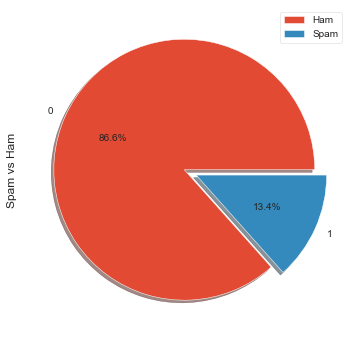

In [51]:
messages["type"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

A lot of messages are actually not spam. About 87% of our dataset consists of normal messages.

Goal : We don't mind if we miss the odd spam message but we surely don't want to mark a ham message as spam i.e Precision is very important. Hence we will use fbeta score as our accuracy metric with inclination towards Precision

### 4.2 Lets see the top spam/ham messages

In [52]:
topMessages = messages.groupby("text")["type"].agg([len, np.max]).sort_values(by = "len", ascending = False).head(n = 10)
display(topMessages)

,len,amax
text,,
sorri ill call later,30,0
ok,20,0
cant pick phone right pls send messag,12,0
oki,7,0
,5,0
ok lor,5,0
wen ur lovabl bcum angri wid u dnt take serious coz angri childish n true way show deep affect care n luv kettoda manda nice day da,4,0
say slowli godi love amp need youclean heart bloodsend ten special peopl amp u c miracl tomorrow itplspl,4,0
pleas call custom servic repres freephon 0808 145 4742 9am11pm guarante å£1000 cash å£5000 prize,4,1


"Sorry, i'll call later" tops the ham message list with 30 counts with "I cant pick the phone right now. Pls send a message" comes second with 12 counts.

And a lot of Ok..., Okie and Ok.

### 4.3 Lets study individual Spam/ham words

In [4]:
spam_messages = messages[messages["type"] == "spam"]["text"]
ham_messages = messages[messages["type"] == "ham"]["text"]

spam_words = []
ham_words = []

# Since this is just classifying the message as spam or ham, we can use isalpha(). 
# This will also remove the not word in something like can't etc. 

def extractSpamWords(spamMessages):
    global spam_words
    words = [word.lower() for word in word_tokenize(spamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    spam_words = spam_words + words
    
def extractHamWords(hamMessages):
    global ham_words
    words = [word.lower() for word in word_tokenize(hamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    ham_words = ham_words + words
spam_messages.apply(extractSpamWords)
ham_messages.apply(extractHamWords)

0       None
1       None
3       None
4       None
6       None
        ... 
5565    None
5568    None
5569    None
5570    None
5571    None
Name: text, Length: 4825, dtype: object

In [5]:
from wordcloud import WordCloud

### 4.4 Spam and Ham Word cloud

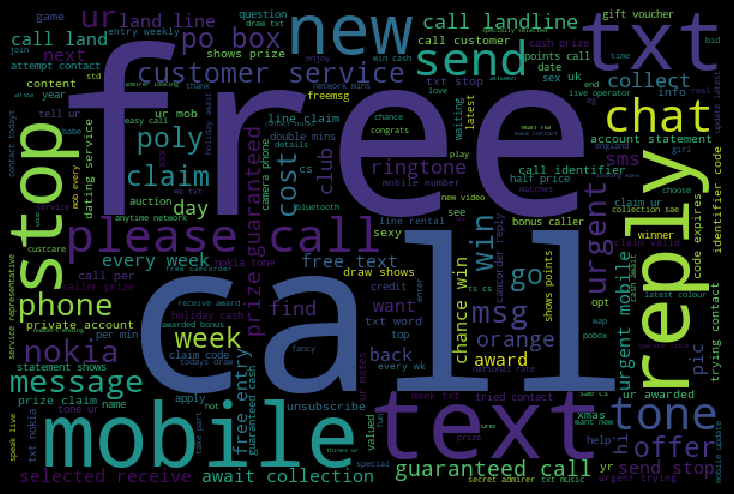

In [6]:
#Spam Word cloud

spam_wordcloud = WordCloud(width=600, height=400).generate(" ".join(spam_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

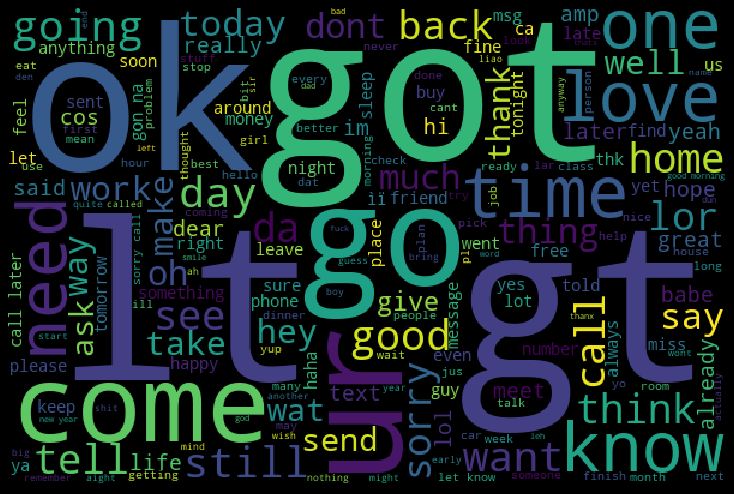

In [7]:
#Ham word cloud

ham_wordcloud = WordCloud(width=600, height=400).generate(" ".join(ham_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### 4.4 Top 10 Spam and Ham Words

In [8]:
# Top 10 spam words

spam_words = np.array(spam_words)
print("Top 10 Spam words are :\n")
pd.Series(spam_words).value_counts().head(n = 10)

Top 10 Spam words are :



call      346
free      217
txt       156
u         144
ur        144
mobile    123
text      121
stop      114
claim     113
reply     104
dtype: int64

In [9]:
# Top 10 Ham words

ham_words = np.array(ham_words)
print("Top 10 Ham words are :\n")
pd.Series(ham_words).value_counts().head(n = 10)

Top 10 Ham words are :



u       974
gt      318
lt      316
get     301
go      246
ok      246
got     242
ur      237
know    234
like    231
dtype: int64

### 4.5 Basic feature extraction using text data

In [10]:
# Number of words

messages['word_count'] = messages['text'].apply(lambda x: len(str(x).split(" ")))
messages[['text','word_count']].head()

,text,word_count
0,"Go until jurong point, crazy.. Available only ...",20
1,Ok lar... Joking wif u oni...,6
2,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,U dun say so early hor... U c already then say...,11
4,"Nah I don't think he goes to usf, he lives aro...",13


In [11]:
# Number of characters

messages['char_count'] = messages['text'].str.len() ## this also includes spaces
messages[['text','char_count']].head()

,text,char_count
0,"Go until jurong point, crazy.. Available only ...",111
1,Ok lar... Joking wif u oni...,29
2,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,U dun say so early hor... U c already then say...,49
4,"Nah I don't think he goes to usf, he lives aro...",61


In [12]:
# Number of stopwords

stop = stopwords.words('english')

messages['stopwords'] = messages['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
messages[['text','stopwords']].head()

,text,stopwords
0,"Go until jurong point, crazy.. Available only ...",4
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,5
3,U dun say so early hor... U c already then say...,2
4,"Nah I don't think he goes to usf, he lives aro...",5


In [13]:
# Number of numerics

messages['numerics'] = messages['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
messages[['text','numerics']].head()

,text,numerics
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,2
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


### 4.6 Does the length of the message indicates us anything?

In [14]:
messages["messageLength"] = messages["text"].apply(len)
messages["messageLength"].describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: messageLength, dtype: float64

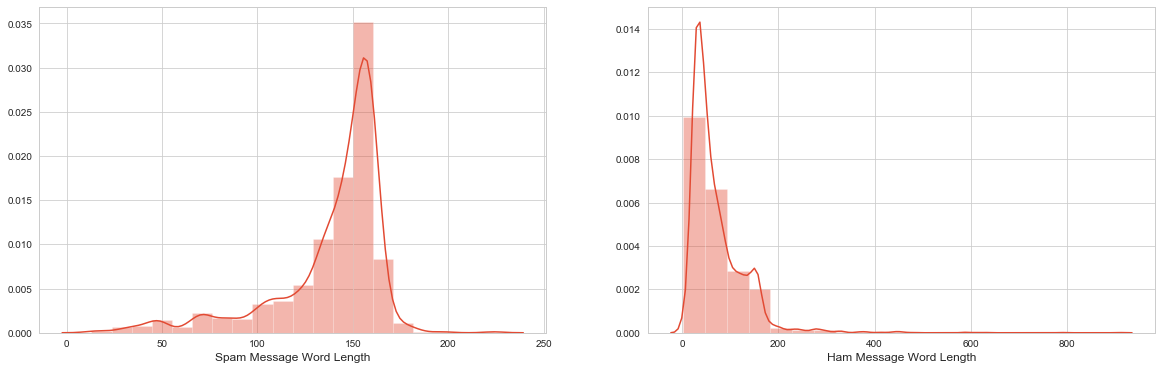

In [15]:
f, ax = plt.subplots(1, 2, figsize = (20, 6))

sns.distplot(messages[messages["type"] == "spam"]["messageLength"], bins = 20, ax = ax[0])
ax[0].set_xlabel("Spam Message Word Length")

sns.distplot(messages[messages["type"] == "ham"]["messageLength"], bins = 20, ax = ax[1])
ax[1].set_xlabel("Ham Message Word Length")

plt.show()

Looks like spam messages are usually longer. Maybe messageLength can become a feature to predict whether the message is spam/ ham ?

## 5.Manipulation of textual data

### 5.1 Text Transformation

#### Lets clean our data by removing punctuations/ stopwords and stemming words

In [16]:
from nltk.stem import SnowballStemmer
import re
stemmer = SnowballStemmer("english")

def cleanText(message):
    message = re.sub(r'<.*?>', '', message)
     # removing the characters [\], ['] and ["]
    message = re.sub(r"\\", "", message)    
    message = re.sub(r"\'", "", message)    
    message = re.sub(r"\"", "", message)
    
    message = message.translate(str.maketrans('', '', string.punctuation))
    words = [stemmer.stem(word) for word in message.split() if word.lower() not in stopwords.words("english")]
    
    return " ".join(words)

messages["text"] = messages["text"].apply(cleanText)
messages.head(n = 10)    

,type,text,Unnamed: 2,Unnamed: 3,Unnamed: 4,word_count,char_count,stopwords,numerics,messageLength
0,ham,go jurong point crazi avail bugi n great world...,NaN,NaN,NaN,20,111,4,0,111
1,ham,ok lar joke wif u oni,NaN,NaN,NaN,6,29,0,0,29
2,spam,free entri 2 wkli comp win fa cup final tkts 2...,NaN,NaN,NaN,28,155,5,2,155
3,ham,u dun say earli hor u c alreadi say,NaN,NaN,NaN,11,49,2,0,49
4,ham,nah dont think goe usf live around though,NaN,NaN,NaN,13,61,5,0,61
5,spam,freemsg hey darl 3 week word back id like fun ...,NaN,NaN,NaN,32,148,13,1,148
6,ham,even brother like speak treat like aid patent,NaN,NaN,NaN,16,77,6,0,77
7,ham,per request mell mell oru minnaminungint nurun...,NaN,NaN,NaN,26,160,9,0,160
8,spam,winner valu network custom select receivea å£9...,NaN,NaN,NaN,26,158,5,1,158
9,spam,mobil 11 month u r entitl updat latest colour ...,NaN,NaN,NaN,29,154,8,2,154


### 5.2 Text Analytics

Frequencies of words in the spam and non-spam messages. The words of the messages will be model features.

We use the function Counter.

In [17]:
count1 = Counter(" ".join(messages[messages["type"]=='ham']["text"]).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})
count2 = Counter(" ".join(messages[messages["type"]=='spam']["text"]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})

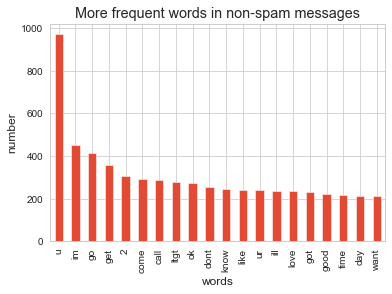

In [18]:
# Plotting most frequent words in non-spam messages

df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

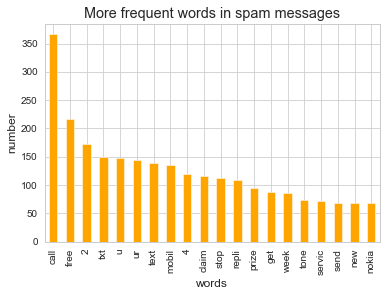

In [19]:
# Plotting most frequent words in Spam messages

df2.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df2["words in spam"]))
plt.xticks(y_pos, df2["words in spam"])
plt.title('More frequent words in spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

Of all the Manipulation techniques listed below: **TFIDF suits us better hence we apply TFIDF to the text data** 

Bag of words<br> 
Document-term matrix<br>
TF-IDF<br>
Word2vec<br>

### 5.3 Converting our clean text into a representation that a machine learning model can understand. Using TFIDF Vectorizer

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(encoding = "latin-1", strip_accents = "unicode", stop_words = "english")
features = vec.fit_transform(messages["text"])
print(features.shape)

(5572, 7899)


In [21]:
def encodeCategory(cat):
    if cat == "spam":
        return 1
    else:
        return 0
        
messages["type"] = messages["type"].apply(encodeCategory)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, messages["type"], stratify = messages["type"], test_size = 0.2)

In [22]:
Acc = {}
F1score = {}
confusion_mat={}
predictions = {}
prediction = dict()

## 6. MODEL APPLICATION

### 6.1 SVM

In [23]:
from sklearn.svm import SVC
val_scores = []
listc = np.linspace(0.5,3,num=4)
listgamma = np.linspace(0.5,3,num=4)
kernel = ['rbf','sigmoid']# 'poly' is doing bad here, let's save some time.
for v in kernel:
    for c in listc:
        for gamma in listgamma:
            svc = SVC(kernel=v, C=c, gamma=gamma,class_weight='balanced')
            #3. The “balanced” mode uses the values of y to automatically adjust weights inversely 
            #   proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
            scores = cross_val_score(svc, X_train, y_train,scoring='f1')
            val_scores.append([np.mean(scores),v, c,gamma])

In [24]:
val_scores = np.array(val_scores)
print('The best scores happens on:',val_scores[val_scores[:,0]==max(val_scores[:,0]),1:],
      ', where F1 =',val_scores[val_scores[:,0]==max(val_scores[:,0]),0])

The best scores happens on: [['sigmoid' '3.0' '0.5']] , where F1 = ['0.906117165956872']


In [25]:
val_scores = []
listc = np.linspace(0.5,2,num=5)
listgamma = np.linspace(0.3,1,num=5)
for c in listc:
    for gamma in listgamma:
        svc = SVC(kernel='sigmoid', C=c, gamma=gamma,class_weight='balanced')
        scores = cross_val_score(svc, X_train, y_train,scoring='f1')
        val_scores.append([np.mean(scores),v, c,gamma])
val_scores = np.array(val_scores)
print('The best scores happens on:',val_scores[val_scores[:,0]==max(val_scores[:,0]),1:],
      ', where F1 =',val_scores[val_scores[:,0]==max(val_scores[:,0]),0])

The best scores happens on: [['sigmoid' '0.875' '0.475']] , where F1 = ['0.9048204976714311']


In [26]:
name = 'SVM'
svc = SVC(kernel='sigmoid', C=1.25, gamma=0.825,class_weight='balanced')
svc.fit(X_train,y_train)
pred = svc.predict(X_test.toarray())
F1score[name]= f1_score(y_test,pred)
Acc[name] = accuracy_score(y_test,pred)
confusion_mat[name] = confusion_matrix(y_test,pred)
predictions[name]=pred
print(name+': Accuracy=%1.3f, F1=%1.3f'%(Acc[name],F1score[name]))

SVM: Accuracy=0.980, F1=0.924


In [27]:
prediction["SVM"] = svc.predict(X_test)

In [28]:
print("F-beta score for SVM:", fbeta_score(y_test, prediction["SVM"], beta = 0.5))

F-beta score for SVM: 0.9432624113475179


### 6.2 Multinomial Naive Bayes
Generally, Naive Bayes works well on text data. Multinomail Naive bayes is best suited for classification with discrete features.

In [29]:
GNB = GaussianNB()
GNB.fit(X_train.toarray(), y_train)# Since our Xtrain is a sparse matrix, need to use .toarray() to convert it to dense one.
accuracy_score(y_test,GNB.predict(X_test.toarray()))

0.8609865470852018

In [30]:
name = 'MNB'
MNB = MultinomialNB(alpha=0.27052632)
MNB.fit(X_train,y_train)
pred = MNB.predict(X_test.toarray())
F1score[name]= f1_score(y_test,pred)
Acc[name] = accuracy_score(y_test,pred)
confusion_mat[name] = confusion_matrix(y_test,pred)
predictions[name]=pred
print(name+': Accuracy=%1.3f, F1=%1.3f'%(Acc[name],F1score[name]))

MNB: Accuracy=0.983, F1=0.934


In [31]:
prediction["Multinomial"] = MNB.predict(X_test)

In [32]:
print("F-beta score for Multinomial Naive Bayes:", fbeta_score(y_test, prediction["Multinomial"], beta = 0.5))

F-beta score for Multinomial Naive Bayes: 0.9520451339915373


### 6.3 Logistic Regression

To prevent overfitting, We usually puts L1 or L2 regularity here. 
A parameter C will help control overfit. Smaller C leads to underfit and vise versa.

In [33]:
list_C = np.linspace(0.1,3,num=20)
val_scores = []
for p in ('l1','l2'):
    for c in list_C:
        LR = LogisticRegression(penalty=p,C=c,class_weight='balanced')
        scores = cross_val_score(LR, X_train, y_train,scoring='f1')
        val_scores.append([np.mean(scores),p,c])
val_scores = np.array(val_scores)
print('The best scores happens on:',val_scores[val_scores[:,0]==max(val_scores[:,0]),1:],
      ', where F1 =',val_scores[val_scores[:,0]==max(val_scores[:,0]),0]) 

The best scores happens on: [['l2' '2.236842105263158']
 ['l2' '2.3894736842105266']
 ['l2' '2.542105263157895']
 ['l2' '2.694736842105263']] , where F1 = ['0.9035179729026561' '0.9035179729026561' '0.9035179729026561'
 '0.9035179729026561']


#### Using, parameter penalty='l2',C=0.863157894737

In [34]:
name = 'LR'
LR = LogisticRegression(penalty='l2',C=0.863157894737,class_weight='balanced')
LR.fit(X_train,y_train)
pred = LR.predict(X_test)
F1score[name]= f1_score(y_test,pred)
Acc[name] = accuracy_score(y_test,pred)
confusion_mat[name] = confusion_matrix(y_test,pred)
predictions[name]=pred
print(name+': Accuracy=%1.3f, F1=%1.3f'%(Acc[name],F1score[name]))

LR: Accuracy=0.981, F1=0.929


In [35]:
prediction["Logistic"] = LR.predict(X_test)

In [36]:
print("F-beta score for LogisticRegression:", fbeta_score(y_test, prediction["Logistic"], beta = 0.5))

F-beta score for LogisticRegression: 0.9311740890688258


## 7. Comparison Between Models

### 7.1 Accuracy and F1 Score

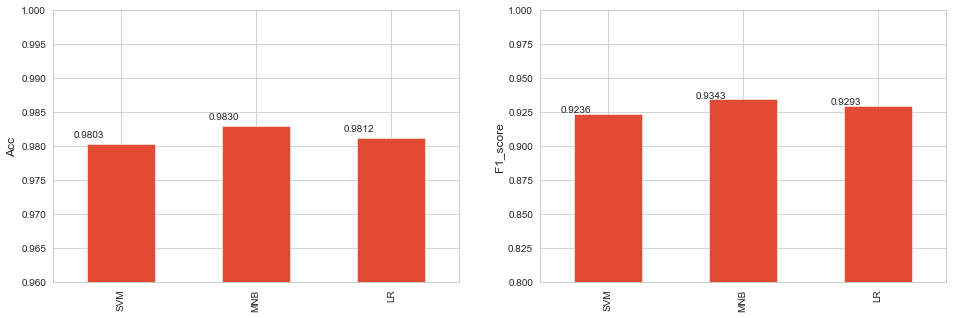

In [37]:
Results = pd.DataFrame([v for v in Acc.values()], columns = ['Acc'],
                    index = [k for k in Acc.keys()])
Results = Results.assign(F1_score=[v for v in F1score.values()])

fig = plt.figure(figsize=(16,5))
ylim = [[0.96,1],[0.8,1]]
x_offset = -0.35; y_offset = 0.001
for i,(a,yl) in enumerate(zip(list(Results.keys()),ylim)):
    plt.subplot(1,2,i+1)
    Results[a].plot(kind='bar')
    plt.ylabel(a); plt.ylim(yl)
    for p in plt.gca().patches:
        b = p.get_bbox()
        val = "{:1.4f}".format(b.y1 + b.y0)        
        plt.gca().annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

As we can see SVM gives a very good Accuracy and F1 score on the test set, LR,MNB, and RF, are trailing behind.

### 7.2 Confusion Matrices

In [38]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout();plt.ylabel('True label');plt.xlabel('Predicted label')

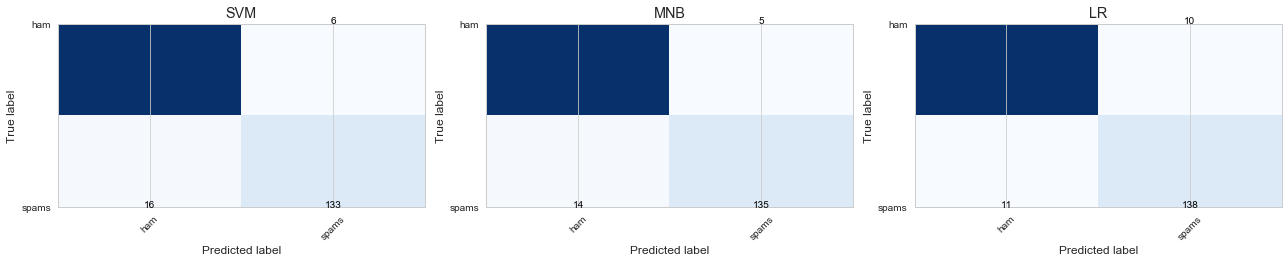

In [39]:
fig = plt.figure(figsize=(18,16))
i=1
for key,val in confusion_mat.items():
    plt.subplot(3,3,i);i+=1
    plot_confusion_matrix(val, classes=['ham','spams'], normalize=False,
                      title=key)

### 7.3 Misclassified samples from SVM

In [40]:
missclassified = np.nonzero(pred!=y_test)[0]
ind_miss = y_test.index[missclassified]
messages.iloc[ind_miss,:]

,type,text,Unnamed: 2,Unnamed: 3,Unnamed: 4,word_count,char_count,stopwords,numerics,messageLength
5008,0,mobil numberpl sms ur mail idconvey regard ach...,NaN,NaN,NaN,10,78,1,0,78
5475,0,dhoni luck win big titleso win,NaN,NaN,NaN,11,54,5,0,54
669,0,u receiv msg,NaN,NaN,NaN,5,21,1,0,21
2246,1,hi ya babe x u 4goten bout scammer get smartth...,NaN,NaN,NaN,31,181,7,0,181
1671,0,glad see repli,NaN,NaN,NaN,5,23,2,0,23
4417,0,get free call,NaN,NaN,NaN,6,26,2,0,26
2378,0,hi mobil ltgt ad contact list wwwfullonsmscom ...,NaN,NaN,NaN,30,158,10,0,158
3888,0,unlimit text limit minut,NaN,NaN,NaN,4,33,0,0,33
730,1,email alertfrom jeri stewarts 2kbsubject lowco...,NaN,NaN,NaN,13,101,1,1,101
2247,1,back 2 work 2morro half term u c 2nite 4 sexi ...,NaN,NaN,NaN,29,160,3,4,160


## 8. Parameter Tuning using GridSearchCV
Based, on the above ML models, SVC has given the best accuracy and F1 Score. So, Let's try to tune the parameters of SVC using GridSearchCV

In [41]:
from sklearn.model_selection import GridSearchCV

In [42]:
param_grid = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}

In [43]:
grid = GridSearchCV(SVC(),param_grid,refit = True, verbose=2)

In [44]:
grid.fit(X_train,y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] C=1, gamma=1, kernel=linear .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.3s
[CV] C=1, gamma=1, kernel=linear .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.3s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.3s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.7s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.7s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.7s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] .................... C=1, gamma=0.1, kernel=linear, total=   0.3s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] .................... C=1, gamma=0.1, kernel=linear, total=   0.4s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] .

[CV] ..................... C=100, gamma=0.1, kernel=rbf, total=   0.4s
[CV] C=100, gamma=0.001, kernel=linear ...............................
[CV] ................ C=100, gamma=0.001, kernel=linear, total=   0.3s
[CV] C=100, gamma=0.001, kernel=linear ...............................
[CV] ................ C=100, gamma=0.001, kernel=linear, total=   0.3s
[CV] C=100, gamma=0.001, kernel=linear ...............................
[CV] ................ C=100, gamma=0.001, kernel=linear, total=   0.3s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ................... C=100, gamma=0.001, kernel=rbf, total=   0.4s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ................... C=100, gamma=0.001, kernel=rbf, total=   0.4s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ................... C=100, gamma=0.001, kernel=rbf, total=   0.4s
[CV] C=100, gamma=0.0001, kernel=linear ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:   37.3s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [45]:
grid.best_params_

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

In [46]:
predic = grid.predict(X_test)

In [47]:
print(classification_report(y_test,predic))
print(confusion_matrix(y_test, predic))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.98      0.87      0.93       149

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

[[964   2]
 [ 19 130]]
